In [1]:
import os
os.environ['PYTORCH_CUDA_ALLOC_CONF'] = ""
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'

In [2]:
# os.chdir('..')

# Data

In [ ]:
from fedcore.data.dataloader import load_data
from fedcore.algorithm.low_rank.svd_tools import decompose_module

input_data = load_data('CIFAR10')


Files already downloaded and verified
Files already downloaded and verified


In [5]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models, transforms
from torch.utils.data import DataLoader, Dataset
from torchmetrics import Accuracy, F1Score, ROC, AUROC

import time
import os
from tqdm import tqdm

In [23]:
# Configuration
config = {
    'batch_size': 32,
    'num_workers': 4,
    'num_epochs': 20,  # Total epochs (will validate every 5)
    'learning_rate': 0.001,
    'weight_decay': 1e-4,
    'device': torch.device('cuda' if torch.cuda.is_available() else 'cpu'),
    'data_dir': 'path_to_your_data',  # Update this
    'num_classes': 10,  # Update based on your task
    'eval_each': 1,
}

# Initialize metrics
def get_metrics(device, num_classes):
    metrics = {
        'accuracy': Accuracy(task='multiclass' if num_classes > 2 else 'binary', num_classes=num_classes).to(device),
        'f1': F1Score(task='multiclass' if num_classes > 2 else 'binary', num_classes=num_classes).to(device),
        'auroc': AUROC(task='multiclass' if num_classes > 2 else 'binary', num_classes=num_classes).to(device)
    }
    return metrics

train_metrics = get_metrics(config['device'], config['num_classes'])
val_metrics = get_metrics(config['device'], config['num_classes'])


In [7]:
train_loader = input_data[0].train_dataloader
val_loader = input_data[0].val_dataloader

# Model

deepen the FC layer to check if we can extrude one layer by forcing it being identity

In [ ]:
# Initialize ResNet-152 model
from torchvision.models import resnet18, ResNet18_Weights

def get_model(*, decompose=False, pretrained=False):
    if pretrained:
        model = resnet18(ResNet18_Weights)
        for p in model.parameters():
            p.requires_grad = False
    else:
        model = resnet18()
    num_ftrs = model.fc.in_features
    model.fc = nn.Sequential(
        nn.Linear(num_ftrs, num_ftrs),
        nn.LeakyReLU(),
        nn.Linear(num_ftrs, config['num_classes'])
    )
    if decompose:
        decompose_module(model, 'channel')
    model = model.to(config['device'])
    return model 

In [ ]:
model = get_model(decompose=True, pretrained=True)
# Loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=config['learning_rate'], weight_decay=config['weight_decay'])

force_to_identity -- проблема в том, что torch.linalg.svd не сходится на совсем уж плохо обусловленных матрицах

In [129]:
def force_to_identity(X, ortho, singular, p=2):
    assert X.size(-1) == X.size(-2)
    device = config['device']
    U, S, Vt = torch.linalg.svd(X, full_matrices=False)
    ortho_component = ortho * torch.pow(U @ Vt - torch.eye(U.size(-1), device=device), p).mean() 
    s_component = singular * torch.pow(S - torch.ones_like(S), p).mean()
    ret = ortho_component + s_component
    return ret

def force_to_identity_dl(layer, ortho, singular, p=2):
    """Version for IDecomposed"""
    device = config['device']
    # U, S, Vt = torch.linalg.svd(X, full_matrices=False)
    if layer.weight.shape[-2] == layer.weight.shape[-1]:
        ortho_component = ortho * torch.pow(layer.U @ layer.Vh - torch.eye(layer.U.size(-1), device=device), p).mean() 
    else:
        ortho_component = 0.
    s_component = singular * torch.pow(layer.S - torch.ones_like(layer.S), p).mean()
    ret = ortho_component + s_component
    return ret

class Force2Iden(nn.Module):
    def __init__(self, names, ortho=10, sing=5, p=2, mode='dl'):
        super().__init__()
        self.ortho = ortho
        self.sing = sing
        self.names = names
        self.p = p
        self.mode = mode

    def forward(self, model):
        res = 0
        for name, layer in model.named_modules():
            if name not in self.names:
                continue
            if self.mode != 'dl':
                W = layer.weight
                res = res + force_to_identity(W, self.ortho, self.sing, self.p)
            else:
                res = res + force_to_identity_dl(layer, self.ortho, self.sing, self.p)
        return res

In [ ]:
# Training and validation function
def train_model(model, path, custom_losses=[]):
    since = time.time()
    best_auc = 0.0
    
    # Initialize metrics storage
    metrics_history = {
        'train_loss': [],
        'val_loss': [],
        'train_acc': [],
        'val_acc': [],
        'train_f1': [],
        'val_f1': [],
        'train_auc': [],
        'val_auc': []
    }
    try:
        for epoch in tqdm(range(config['num_epochs']), desc='Epoch'):
            print(f'Epoch {epoch+1}/{config["num_epochs"]}')
            print('-' * 10)
            
            # Each epoch has a training and validation phase
            for phase in ['train', 'val']:
                if phase == 'train':
                    model.train()  # Set model to training mode
                    dataloader = train_loader
                    metrics = train_metrics
                else:
                    # Only validate every 5 epochs
                    if (epoch + 1) % config['eval_each'] != 0 and epoch + 1 != config['num_epochs']:
                        break
                    model.eval()   # Set model to evaluate mode
                    dataloader = val_loader
                    metrics = val_metrics
                
                running_loss = 0.0
                
                # Reset metrics for this epoch
                for metric in metrics.values():
                    metric.reset()
                
                # Iterate over data
                for inputs, labels in tqdm(dataloader, desc=phase):
                    inputs = inputs.to(config['device'])
                    labels = labels.to(config['device'])
                    
                    # Zero the parameter gradients
                    optimizer.zero_grad()
                    
                    # Forward
                    with torch.set_grad_enabled(phase == 'train'):
                        outputs = model(inputs)
                        # Using softmax (multiple output neurons)
                        probs = torch.nn.functional.softmax(outputs, dim=-1)
                        preds = torch.argmax(probs, dim=1)  # Shape [batch_size]
                        # _, preds = torch.max(outputs, 1)
                        # print(outputs.size(), targets.size(), probs.size())
                        # return
                        loss = criterion(outputs, labels)
                        for cstls in custom_losses:
                            loss = loss + cstls(model)
                        
                        # Backward + optimize only if in training phase
                        if phase == 'train':
                            loss.backward()
                            optimizer.step()
                    
                    # Statistics
                    running_loss += loss.item() * inputs.size(0)
                    
                    # Update metrics
                    for name, metric in metrics.items():
                        if name == 'auroc':
                            # continue
                            # print(name, probs.size(), labels.size())
                            metric.update(probs, labels)
                        else:
                            # print(name, preds.size(), labels.size())
                            metric.update(preds, labels)
                
                epoch_loss = running_loss / len(dataloader.dataset)
                
                # Compute metrics
                epoch_acc = metrics['accuracy'].compute().item()
                epoch_f1 = metrics['f1'].compute().item()
                epoch_auc = metrics['auroc'].compute().item()
                
                # Store metrics
                if phase == 'train':
                    metrics_history['train_loss'].append(epoch_loss)
                    metrics_history['train_acc'].append(epoch_acc)
                    metrics_history['train_f1'].append(epoch_f1)
                    metrics_history['train_auc'].append(epoch_auc)
                    
                    print(f'Train Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f} '
                        f'F1: {epoch_f1:.4f} AUC: {epoch_auc:.4f}')
                else:
                    metrics_history['val_loss'].append(epoch_loss)
                    metrics_history['val_acc'].append(epoch_acc)
                    metrics_history['val_f1'].append(epoch_f1)
                    metrics_history['val_auc'].append(epoch_auc)
                    
                    print(f'Val Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f} '
                        f'F1: {epoch_f1:.4f} AUC: {epoch_auc:.4f}')
                    
                    # Deep copy the model if it's the best so far
                    if epoch_auc > best_auc:
                        best_auc = epoch_auc
                        best_model_wts = model.state_dict()
        
        time_elapsed = time.time() - since
        print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
        print(f'Best Val AUC: {best_auc:.4f}')
    except KeyboardInterrupt:
        pass        
    
    # Load best model weights
    model.load_state_dict(best_model_wts)
    torch.save(model, path)
    return model, metrics_history


Case: no reg

In [76]:
# Run training
trained_model, metrics_history = train_model(model, 'resnet18_orig.pth')

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1/20
----------


train: 100%|██████████| 782/782 [00:06<00:00, 115.25it/s]


Train Loss: nan Acc: 0.1000 F1: 0.1000 AUC: 0.5000


Epoch:   5%|▌         | 1/20 [00:08<02:38,  8.35s/it]

Val Loss: nan Acc: 0.1000 F1: 0.1000 AUC: 0.5000
Epoch 2/20
----------


Epoch:   5%|▌         | 1/20 [00:11<03:30, 11.10s/it]


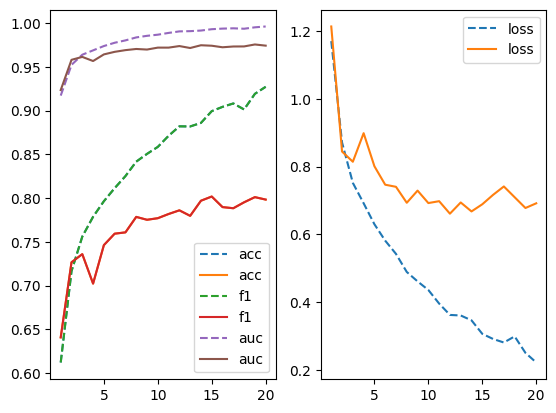

In [30]:
import matplotlib.pyplot as plt
import numpy as np

def plot_history(records, eval_step=5):
    fig, axes = plt.subplots(1, 2)
    def select(ax, exclude=None, include=None):
        for name, history in records.items():
            if include and not name.endswith(include):
                continue
            if exclude and name.endswith(exclude):
                continue
            phase, name = name.split('_')
            if phase == 'train':
                ax.plot(np.arange(1, len(history) + 1), history, label=name, ls='--')
            else:
                ax.plot(np.arange(1, len(history) * eval_step + 1, eval_step), history, label=name)
            ax.legend()
    select(axes[0], exclude='loss')
    select(axes[1], include='loss')
    # plt.legend()


plot_history(metrics_history, config['eval_each'])

In [40]:
W = model.fc[0].U @ torch.diag(model.fc[0].S) @ model.fc[0].Vh

In [ ]:
def check_w(W):
    print(f'Distance from identity:', (W - torch.eye(int(W.shape[-1]), device=W.device)).abs().sum())
    S = torch.linalg.svdvals(W)
    S = S.detach().cpu().numpy()
    plt.plot(S)
    plt.title('Singular values')

Distance from identity: tensor(4029.1777, device='cuda:0', grad_fn=<SumBackward0>)


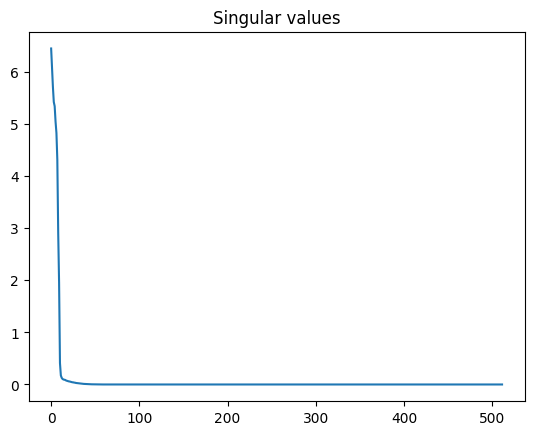

In [ ]:
W = model.fc[0].weight
check_w(W)

## Case: Strong Force2Iden

In [82]:
model = get_model(decompose=False, pretrained=True)
# Loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=config['learning_rate'], weight_decay=config['weight_decay'])


* xavier, orthogonal -- не сходится
* kaiming_normal_ -- сходится плохо (5 эпох)

In [84]:
torch.nn.init.orthogonal_(model.fc[0].weight)

Parameter containing:
tensor([[ 0.0339,  0.0537, -0.0178,  ...,  0.0255,  0.0063,  0.0190],
        [ 0.0385,  0.0622,  0.0414,  ..., -0.0701,  0.0624, -0.0421],
        [ 0.1141,  0.0298, -0.0062,  ..., -0.0452,  0.0214, -0.0374],
        ...,
        [ 0.0760, -0.0062,  0.0653,  ..., -0.0505, -0.0290,  0.0162],
        [-0.0008,  0.0263,  0.0798,  ...,  0.0125, -0.0047,  0.0586],
        [ 0.0501, -0.0266,  0.0389,  ...,  0.0565, -0.0790,  0.0162]],
       device='cuda:0', requires_grad=True)

In [ ]:
# Run training
trained_model, metrics_history = train_model(model, 'resnet18_strong_force2ind.pth', 
                                             [Force2Iden(['fc.0'],)])

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1/20
----------


Epoch:   0%|          | 0/20 [00:02<?, ?it/s]


_LinAlgError: linalg.svd: The algorithm failed to converge because the input matrix is ill-conditioned or has too many repeated singular values (error code: 511).

## Decomposed Resnet

In [103]:
model = get_model(decompose=False, pretrained=True)
decompose_module(model.fc)
start_vals = (model.fc[0].U.clone(), model.fc[0].S.clone(), model.fc[0].Vh.clone())
model.to(config['device']);
# Loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=config['learning_rate'], weight_decay=config['weight_decay'])


In [104]:
# Run training
trained_model, metrics_history = train_model(model, 'resnet18_orig.pth', 
                                             [Force2Iden(['fc.0'], 0.1, 0.05)])

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1/20
----------


train: 100%|██████████| 782/782 [00:07<00:00, 100.21it/s]


Train Loss: 1.6831 Acc: 0.4111 F1: 0.4111 AUC: 0.8322


Epoch:   5%|▌         | 1/20 [00:09<02:57,  9.32s/it]

Val Loss: 1.5741 Acc: 0.4612 F1: 0.4612 AUC: 0.8619
Epoch 2/20
----------


train: 100%|██████████| 782/782 [00:07<00:00, 102.95it/s]


Train Loss: 1.5605 Acc: 0.4538 F1: 0.4538 AUC: 0.8589


Epoch:  10%|█         | 2/20 [00:18<02:46,  9.24s/it]

Val Loss: 1.5423 Acc: 0.4632 F1: 0.4632 AUC: 0.8664
Epoch 3/20
----------


train: 100%|██████████| 782/782 [00:07<00:00, 100.33it/s]


Train Loss: 1.5240 Acc: 0.4677 F1: 0.4677 AUC: 0.8659


Epoch:  15%|█▌        | 3/20 [00:27<02:37,  9.27s/it]

Val Loss: 1.5496 Acc: 0.4533 F1: 0.4533 AUC: 0.8662
Epoch 4/20
----------


train: 100%|██████████| 782/782 [00:07<00:00, 103.05it/s]


Train Loss: 1.5003 Acc: 0.4762 F1: 0.4762 AUC: 0.8703


Epoch:  20%|██        | 4/20 [00:36<02:27,  9.20s/it]

Val Loss: 1.5391 Acc: 0.4626 F1: 0.4626 AUC: 0.8674
Epoch 5/20
----------


train: 100%|██████████| 782/782 [00:07<00:00, 101.74it/s]


Train Loss: 1.4770 Acc: 0.4823 F1: 0.4823 AUC: 0.8746


Epoch:  25%|██▌       | 5/20 [00:46<02:17,  9.19s/it]

Val Loss: 1.5298 Acc: 0.4671 F1: 0.4671 AUC: 0.8693
Epoch 6/20
----------


train: 100%|██████████| 782/782 [00:07<00:00, 104.89it/s]


Train Loss: 1.4594 Acc: 0.4905 F1: 0.4905 AUC: 0.8781


Epoch:  30%|███       | 6/20 [00:55<02:07,  9.11s/it]

Val Loss: 1.4955 Acc: 0.4837 F1: 0.4837 AUC: 0.8744
Epoch 7/20
----------


train: 100%|██████████| 782/782 [00:07<00:00, 110.96it/s]


Train Loss: 1.4406 Acc: 0.4984 F1: 0.4984 AUC: 0.8813


Epoch:  35%|███▌      | 7/20 [01:03<01:55,  8.92s/it]

Val Loss: 1.5106 Acc: 0.4740 F1: 0.4740 AUC: 0.8727
Epoch 8/20
----------


train: 100%|██████████| 782/782 [00:07<00:00, 99.45it/s] 


Train Loss: 1.4303 Acc: 0.4983 F1: 0.4983 AUC: 0.8830


Epoch:  40%|████      | 8/20 [01:12<01:48,  9.07s/it]

Val Loss: 1.5397 Acc: 0.4710 F1: 0.4710 AUC: 0.8718
Epoch 9/20
----------


train: 100%|██████████| 782/782 [00:07<00:00, 102.01it/s]


Train Loss: 1.4125 Acc: 0.5074 F1: 0.5074 AUC: 0.8864


Epoch:  45%|████▌     | 9/20 [01:22<01:40,  9.12s/it]

Val Loss: 1.4805 Acc: 0.4938 F1: 0.4938 AUC: 0.8764
Epoch 10/20
----------


train: 100%|██████████| 782/782 [00:07<00:00, 103.61it/s]


Train Loss: 1.4069 Acc: 0.5076 F1: 0.5076 AUC: 0.8873


Epoch:  50%|█████     | 10/20 [01:31<01:31,  9.13s/it]

Val Loss: 1.5017 Acc: 0.4824 F1: 0.4824 AUC: 0.8743
Epoch 11/20
----------


train: 100%|██████████| 782/782 [00:07<00:00, 104.51it/s]


Train Loss: 1.3920 Acc: 0.5144 F1: 0.5144 AUC: 0.8901


Epoch:  55%|█████▌    | 11/20 [01:40<01:21,  9.09s/it]

Val Loss: 1.4703 Acc: 0.4958 F1: 0.4958 AUC: 0.8784
Epoch 12/20
----------


train: 100%|██████████| 782/782 [00:07<00:00, 103.71it/s]


Train Loss: 1.3883 Acc: 0.5165 F1: 0.5165 AUC: 0.8907


Epoch:  60%|██████    | 12/20 [01:49<01:12,  9.10s/it]

Val Loss: 1.4962 Acc: 0.4861 F1: 0.4861 AUC: 0.8757
Epoch 13/20
----------


train: 100%|██████████| 782/782 [00:07<00:00, 103.45it/s]


Train Loss: 1.3766 Acc: 0.5203 F1: 0.5203 AUC: 0.8926


Epoch:  65%|██████▌   | 13/20 [01:58<01:03,  9.09s/it]

Val Loss: 1.4768 Acc: 0.4917 F1: 0.4917 AUC: 0.8787
Epoch 14/20
----------


train: 100%|██████████| 782/782 [00:07<00:00, 101.34it/s]


Train Loss: 1.3634 Acc: 0.5218 F1: 0.5218 AUC: 0.8949


Epoch:  70%|███████   | 14/20 [02:07<00:54,  9.14s/it]

Val Loss: 1.4883 Acc: 0.4860 F1: 0.4860 AUC: 0.8773
Epoch 15/20
----------


train: 100%|██████████| 782/782 [00:07<00:00, 104.62it/s]


Train Loss: 1.3647 Acc: 0.5258 F1: 0.5258 AUC: 0.8946


Epoch:  75%|███████▌  | 15/20 [02:16<00:45,  9.09s/it]

Val Loss: 1.4747 Acc: 0.4956 F1: 0.4956 AUC: 0.8792
Epoch 16/20
----------


train: 100%|██████████| 782/782 [00:07<00:00, 102.51it/s]


Train Loss: 1.3541 Acc: 0.5262 F1: 0.5262 AUC: 0.8966


Epoch:  80%|████████  | 16/20 [02:25<00:36,  9.11s/it]

Val Loss: 1.4686 Acc: 0.4946 F1: 0.4946 AUC: 0.8792
Epoch 17/20
----------


train: 100%|██████████| 782/782 [00:07<00:00, 100.11it/s]


Train Loss: 1.3489 Acc: 0.5312 F1: 0.5312 AUC: 0.8972


Epoch:  85%|████████▌ | 17/20 [02:35<00:27,  9.19s/it]

Val Loss: 1.4821 Acc: 0.4987 F1: 0.4987 AUC: 0.8791
Epoch 18/20
----------


train: 100%|██████████| 782/782 [00:07<00:00, 103.86it/s]


Train Loss: 1.3382 Acc: 0.5312 F1: 0.5312 AUC: 0.8992


Epoch:  90%|█████████ | 18/20 [02:44<00:18,  9.16s/it]

Val Loss: 1.4733 Acc: 0.4988 F1: 0.4988 AUC: 0.8784
Epoch 19/20
----------


train: 100%|██████████| 782/782 [00:07<00:00, 99.54it/s] 


Train Loss: 1.3327 Acc: 0.5344 F1: 0.5344 AUC: 0.9002


Epoch:  95%|█████████▌| 19/20 [02:53<00:09,  9.22s/it]

Val Loss: 1.4716 Acc: 0.4971 F1: 0.4971 AUC: 0.8806
Epoch 20/20
----------


train: 100%|██████████| 782/782 [00:07<00:00, 101.68it/s]


Train Loss: 1.3286 Acc: 0.5358 F1: 0.5358 AUC: 0.9008


Epoch: 100%|██████████| 20/20 [03:02<00:00,  9.15s/it]


Val Loss: 1.4745 Acc: 0.4990 F1: 0.4990 AUC: 0.8793
Training complete in 3m 3s
Best Val AUC: 0.8806


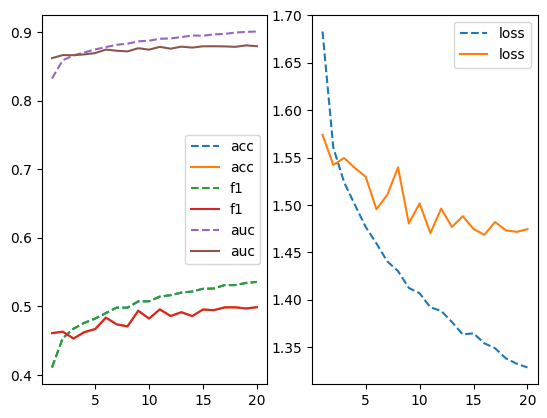

In [105]:
plot_history(metrics_history, 1)

In [ ]:
def check_dl(dl):
    U, S, Vh = dl.U, dl.S, dl.Vh
    W = (U * S) @ Vh 
    print(f'Distance from identity:', (W - torch.eye(int(W.shape[-1]), device=W.device)).abs().sum())
    S = torch.linalg.svdvals(W)
    S = S.detach().cpu().numpy()
    plt.plot(S)
    plt.title('Singular values')


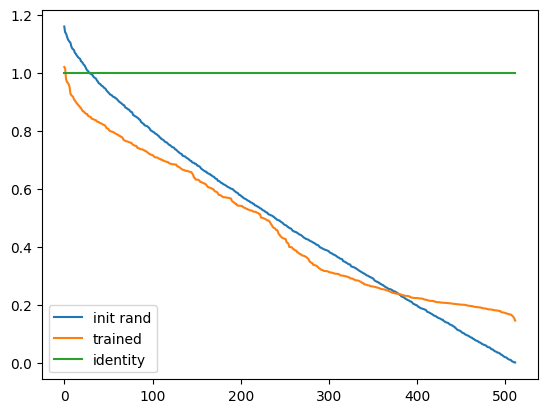

In [111]:
plt.plot(start_vals[1].detach().cpu().numpy(), label='init rand')
plt.plot(sorted(model.fc[0].S.detach().cpu().numpy(), reverse=True), label='trained')
plt.plot(np.ones(model.fc[0].out_features), label='identity')
plt.legend()

## Stronger Cond

In [112]:
model = get_model(decompose=False, pretrained=True)
decompose_module(model.fc)
start_vals = (model.fc[0].U.clone(), model.fc[0].S.clone(), model.fc[0].Vh.clone())
model.to(config['device']);
# Loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=config['learning_rate'], weight_decay=config['weight_decay'])


In [113]:
# Run training
trained_model, metrics_history = train_model(model, 'resnet18_orig.pth', 
                                             [Force2Iden(['fc.0'], 20, 10)])

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1/20
----------


train: 100%|██████████| 782/782 [00:08<00:00, 95.52it/s]


Train Loss: 3.0851 Acc: 0.4081 F1: 0.4081 AUC: 0.8316


Epoch:   5%|▌         | 1/20 [00:09<03:03,  9.68s/it]

Val Loss: 1.9752 Acc: 0.4275 F1: 0.4275 AUC: 0.8515
Epoch 2/20
----------


train: 100%|██████████| 782/782 [00:07<00:00, 97.93it/s] 


Train Loss: 1.7247 Acc: 0.4505 F1: 0.4505 AUC: 0.8546


Epoch:  10%|█         | 2/20 [00:19<02:51,  9.55s/it]

Val Loss: 1.6397 Acc: 0.4554 F1: 0.4554 AUC: 0.8621
Epoch 3/20
----------


train: 100%|██████████| 782/782 [00:08<00:00, 96.87it/s] 


Train Loss: 1.6158 Acc: 0.4604 F1: 0.4604 AUC: 0.8620


Epoch:  15%|█▌        | 3/20 [00:28<02:42,  9.55s/it]

Val Loss: 1.6182 Acc: 0.4579 F1: 0.4579 AUC: 0.8648
Epoch 4/20
----------


train: 100%|██████████| 782/782 [00:08<00:00, 97.05it/s] 


Train Loss: 1.5979 Acc: 0.4652 F1: 0.4652 AUC: 0.8653


Epoch:  20%|██        | 4/20 [00:38<02:32,  9.55s/it]

Val Loss: 1.6360 Acc: 0.4531 F1: 0.4531 AUC: 0.8629
Epoch 5/20
----------


train: 100%|██████████| 782/782 [00:08<00:00, 96.81it/s] 


Train Loss: 1.5884 Acc: 0.4702 F1: 0.4702 AUC: 0.8668


Epoch:  25%|██▌       | 5/20 [00:47<02:23,  9.58s/it]

Val Loss: 1.5777 Acc: 0.4789 F1: 0.4789 AUC: 0.8712
Epoch 6/20
----------


train: 100%|██████████| 782/782 [00:08<00:00, 94.85it/s]


Train Loss: 1.5789 Acc: 0.4702 F1: 0.4702 AUC: 0.8689


Epoch:  30%|███       | 6/20 [00:57<02:14,  9.64s/it]

Val Loss: 1.6058 Acc: 0.4656 F1: 0.4656 AUC: 0.8688
Epoch 7/20
----------


train: 100%|██████████| 782/782 [00:08<00:00, 96.83it/s] 


Train Loss: 1.5721 Acc: 0.4760 F1: 0.4760 AUC: 0.8701


Epoch:  35%|███▌      | 7/20 [01:07<02:05,  9.62s/it]

Val Loss: 1.5989 Acc: 0.4679 F1: 0.4679 AUC: 0.8684
Epoch 8/20
----------


train: 100%|██████████| 782/782 [00:07<00:00, 98.40it/s] 


Train Loss: 1.5580 Acc: 0.4806 F1: 0.4806 AUC: 0.8725


Epoch:  40%|████      | 8/20 [01:16<01:54,  9.58s/it]

Val Loss: 1.6114 Acc: 0.4680 F1: 0.4680 AUC: 0.8660
Epoch 9/20
----------


train: 100%|██████████| 782/782 [00:08<00:00, 96.49it/s] 


Train Loss: 1.5542 Acc: 0.4801 F1: 0.4801 AUC: 0.8734


Epoch:  45%|████▌     | 9/20 [01:26<01:45,  9.60s/it]

Val Loss: 1.5775 Acc: 0.4771 F1: 0.4771 AUC: 0.8710
Epoch 10/20
----------


train: 100%|██████████| 782/782 [00:08<00:00, 97.41it/s] 


Train Loss: 1.5429 Acc: 0.4843 F1: 0.4843 AUC: 0.8755


Epoch:  50%|█████     | 10/20 [01:35<01:35,  9.58s/it]

Val Loss: 1.5892 Acc: 0.4700 F1: 0.4700 AUC: 0.8693
Epoch 11/20
----------


train: 100%|██████████| 782/782 [00:07<00:00, 97.83it/s] 


Train Loss: 1.5430 Acc: 0.4871 F1: 0.4871 AUC: 0.8755


Epoch:  55%|█████▌    | 11/20 [01:45<01:26,  9.56s/it]

Val Loss: 1.5775 Acc: 0.4832 F1: 0.4832 AUC: 0.8707
Epoch 12/20
----------


train: 100%|██████████| 782/782 [00:07<00:00, 98.14it/s] 


Train Loss: 1.5388 Acc: 0.4848 F1: 0.4848 AUC: 0.8762


Epoch:  60%|██████    | 12/20 [01:54<01:16,  9.55s/it]

Val Loss: 1.5559 Acc: 0.4813 F1: 0.4813 AUC: 0.8744
Epoch 13/20
----------


train: 100%|██████████| 782/782 [00:07<00:00, 99.98it/s] 


Train Loss: 1.5374 Acc: 0.4879 F1: 0.4879 AUC: 0.8763


Epoch:  65%|██████▌   | 13/20 [02:04<01:06,  9.49s/it]

Val Loss: 1.5576 Acc: 0.4868 F1: 0.4868 AUC: 0.8751
Epoch 14/20
----------


train: 100%|██████████| 782/782 [00:07<00:00, 99.08it/s] 


Train Loss: 1.5278 Acc: 0.4880 F1: 0.4880 AUC: 0.8783


Epoch:  70%|███████   | 14/20 [02:13<00:56,  9.47s/it]

Val Loss: 1.5771 Acc: 0.4782 F1: 0.4782 AUC: 0.8725
Epoch 15/20
----------


train: 100%|██████████| 782/782 [00:07<00:00, 99.51it/s] 


Train Loss: 1.5262 Acc: 0.4915 F1: 0.4915 AUC: 0.8787


Epoch:  75%|███████▌  | 15/20 [02:23<00:47,  9.44s/it]

Val Loss: 1.5812 Acc: 0.4819 F1: 0.4819 AUC: 0.8721
Epoch 16/20
----------


train: 100%|██████████| 782/782 [00:07<00:00, 99.06it/s] 


Train Loss: 1.5205 Acc: 0.4931 F1: 0.4931 AUC: 0.8796


Epoch:  80%|████████  | 16/20 [02:32<00:37,  9.43s/it]

Val Loss: 1.5817 Acc: 0.4772 F1: 0.4772 AUC: 0.8717
Epoch 17/20
----------


train: 100%|██████████| 782/782 [00:07<00:00, 99.97it/s] 


Train Loss: 1.5176 Acc: 0.4947 F1: 0.4947 AUC: 0.8799


Epoch:  85%|████████▌ | 17/20 [02:41<00:28,  9.39s/it]

Val Loss: 1.5620 Acc: 0.4793 F1: 0.4793 AUC: 0.8747
Epoch 18/20
----------


train: 100%|██████████| 782/782 [00:07<00:00, 99.46it/s] 


Train Loss: 1.5181 Acc: 0.4921 F1: 0.4921 AUC: 0.8800


Epoch:  90%|█████████ | 18/20 [02:51<00:18,  9.37s/it]

Val Loss: 1.5562 Acc: 0.4864 F1: 0.4864 AUC: 0.8743
Epoch 19/20
----------


train: 100%|██████████| 782/782 [00:07<00:00, 99.10it/s] 


Train Loss: 1.5111 Acc: 0.4969 F1: 0.4969 AUC: 0.8815


Epoch:  95%|█████████▌| 19/20 [03:00<00:09,  9.39s/it]

Val Loss: 1.5483 Acc: 0.4943 F1: 0.4943 AUC: 0.8758
Epoch 20/20
----------


train: 100%|██████████| 782/782 [00:07<00:00, 101.38it/s]


Train Loss: 1.5083 Acc: 0.4964 F1: 0.4964 AUC: 0.8818


Epoch: 100%|██████████| 20/20 [03:09<00:00,  9.49s/it]


Val Loss: 1.5675 Acc: 0.4776 F1: 0.4776 AUC: 0.8741
Training complete in 3m 10s
Best Val AUC: 0.8758


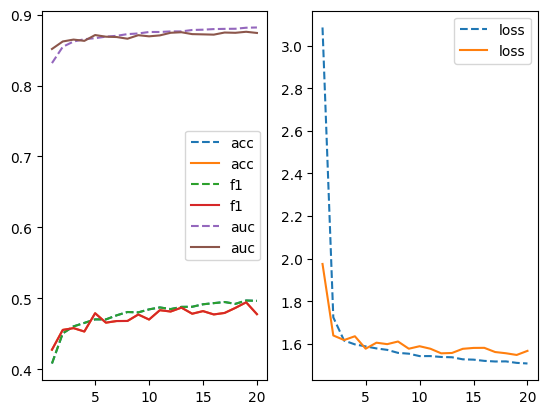

In [116]:
plot_history(metrics_history, 1)

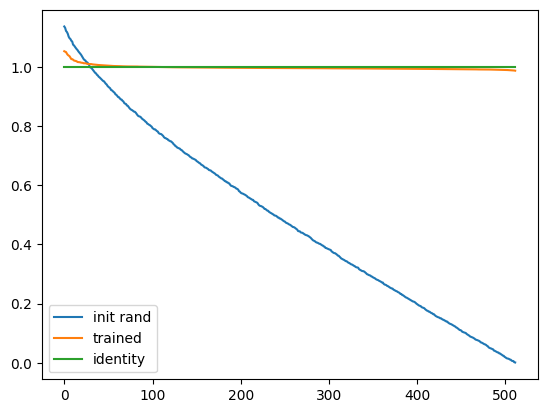

In [117]:
plt.plot(start_vals[1].detach().cpu().numpy(), label='init rand')
plt.plot(sorted(model.fc[0].S.detach().cpu().numpy(), reverse=True), label='trained')
plt.plot(np.ones(model.fc[0].out_features), label='identity')
plt.legend()

*actually, it's far from identity...*

In [128]:
(model.fc[0].U * model.fc[0].S) @  model.fc[0].Vh

tensor([[ 0.3466, -0.0024,  0.0203,  ..., -0.0033, -0.0321, -0.0292],
        [ 0.0163,  0.3855, -0.0845,  ..., -0.0061, -0.0178, -0.0504],
        [ 0.0995, -0.0823,  0.4355,  ..., -0.0227, -0.0112, -0.0207],
        ...,
        [ 0.1428,  0.0369,  0.0166,  ...,  0.2631,  0.1164, -0.1104],
        [ 0.0661,  0.0353, -0.0962,  ..., -0.0850,  0.3350, -0.1545],
        [-0.0139, -0.0262, -0.0045,  ..., -0.0094, -0.0028,  0.3539]],
       device='cuda:0', grad_fn=<MmBackward0>)

# Other losses

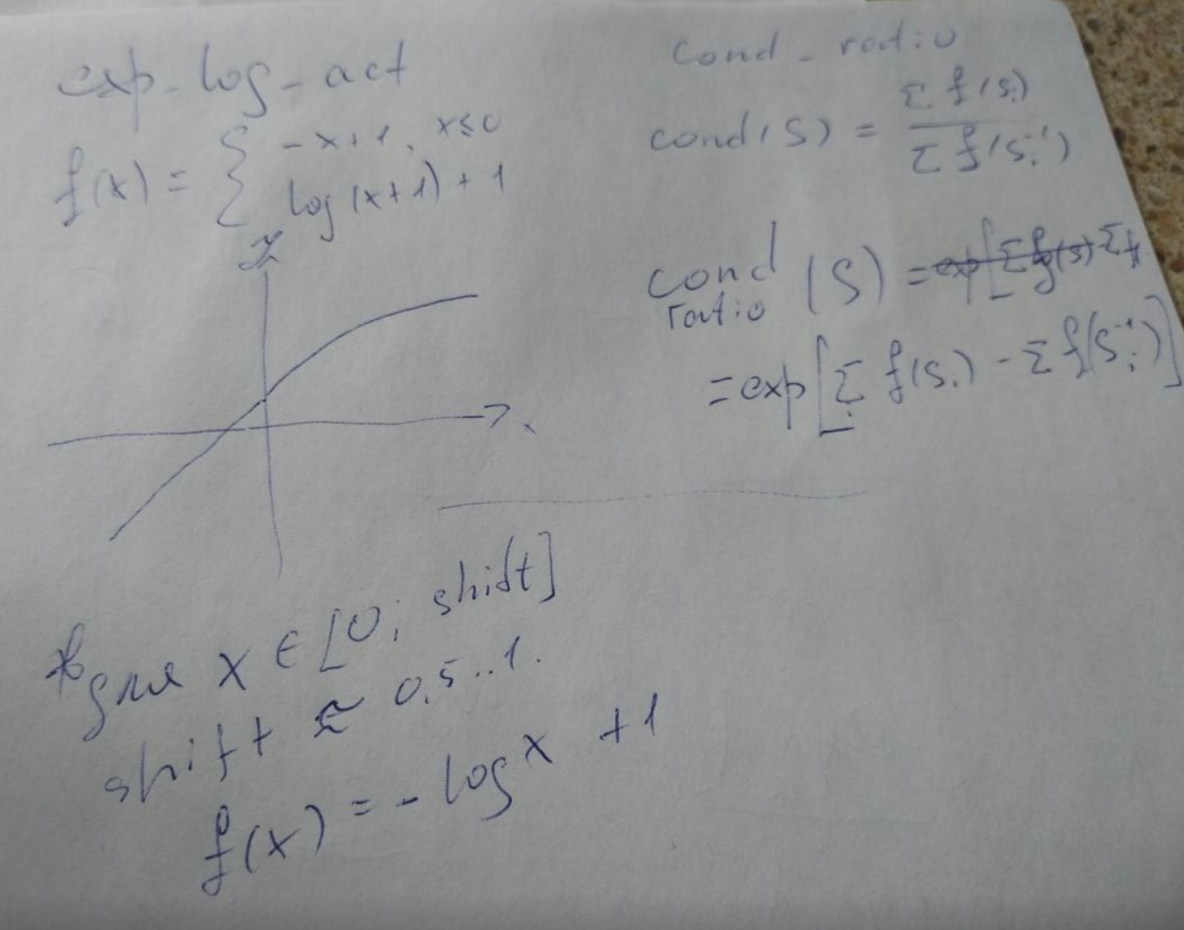

Why negative? 

We have some training process and not all(S >=0) 

In [145]:
import torch 
from fedcore.models.network_impl.decomposed_layers import IDecomposed

def exp_log_activation(x: torch.Tensor, max=1e8):
    negative = -x + 1 
    positive = torch.log(x + 1) + 1 
    result = torch.maximum(negative, positive)
    return torch.clamp(result, max=max)

def exp_log_activation_inv(x: torch.Tensor, thr=0.01, max=1e8):
    result = torch.zeros_like(x)
    neg_mask = x < 0
    result[neg_mask] = -x[neg_mask] + 1 # вообще, тут должно быть обратное и отрицательное, но
    # там возникают новые проблемы с тем, как обрабатывать ->0-0

    lt_thr_mask = (x <= thr).logical_and(~neg_mask)
    result[lt_thr_mask] = -torch.log(x[lt_thr_mask]) + 1
    gt_thr_mask = x >= thr
    result[gt_thr_mask] = torch.log(x[gt_thr_mask] + 1) + 1
    return torch.clamp(result, max=max)

def exp_log_activation2(x: torch.Tensor, max=1e8):
    negative = -x + 1
    mask = x <= 1
    result = torch.zeros_like(x)
    result[mask] = torch.log(x[mask] + 1) + 1 
    result[~mask] = -torch.log(x[~mask]) + 1
    result = torch.maximum(negative, result)
    return torch.clamp(result, max=max)

def cond_loss(S, eps=1e-8):
    S = S + eps
    return torch.log(
        torch.exp(S).sum() / torch.exp(1 / S).sum()
    )

def cond_ratio(S: torch.Tensor, eps=1e-6):
    S = S + eps
    return exp_log_activation(S).sum() / exp_log_activation_inv(S).sum()

def cond_exp(S: torch.Tensor, eps=1e-6):
    S = S + eps
    return torch.exp(
        exp_log_activation2(S).sum() - exp_log_activation_inv(S).sum()
    )

def L1_shift(S: torch.Tensor, shift=1):
    S = S + shift
    return torch.abs(S).sum() / torch.abs(1 / S).sum()

class CondLoss(torch.nn.Module):
    def forward(self, model: torch.nn.Module):
        value = 0.
        for layer in model.modules():
            if not isinstance(IDecomposed) or not hasattr(layer, 'S'):
                continue
            value = value + cond_loss(layer)
        return value   
            

In [131]:
def gen_s(n_zeros=5):
    scale = 10
    shift = 20
    S = torch.randn(10) * scale
    S[:n_zeros] = torch.randn(n_zeros) / scale
    S -= S.min() + 1e-8
    S.requires_grad = True
    return S


In [132]:
S = gen_s(3)
L1_shift(S, shift=5e-1).backward()
S.grad

tensor([0.2881, 0.2898, 0.2936, 0.2900, 0.6212, 7.5853, 0.7475, 0.2296, 1.3681,
        0.2204])

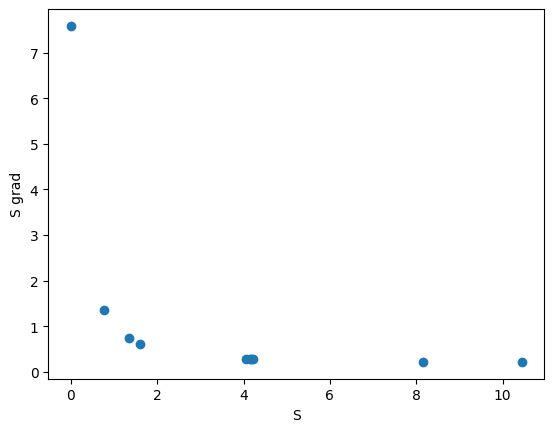

In [136]:
def plot_S_Sgrad(S):
    plt.scatter(
        S.detach().numpy(), 
        S.grad.detach().numpy()
    );
    plt.xlabel('S')
    plt.ylabel('S grad');

plot_S_Sgrad(S)

In [137]:
S = gen_s()
exp_log_activation(S).sum().backward()
S.grad

tensor([0.0796, 0.0788, 0.0794, 0.0794, 0.0794, 0.0700, 0.1946, 0.4080, 0.4068,
        0.0000])

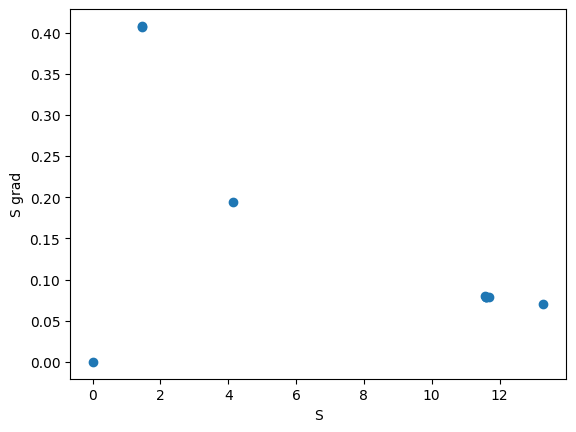

In [138]:
plot_S_Sgrad(S)

tensor([-0.0705, -0.0701, -0.0704, -0.0715, -0.0709, -0.1246, -0.1257,  0.0000,
        -0.0315, -0.4622])

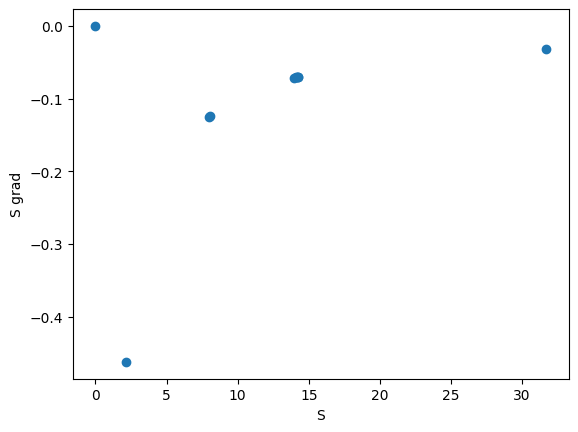

In [139]:
S = gen_s()
exp_log_activation2(S).sum().backward()
plot_S_Sgrad(S)
S.grad

tensor([4.7920e-04, 4.8009e-04, 4.7808e-04, 4.7361e-04, 4.7690e-04, 1.4848e+04,
        2.2377e-04, 5.4344e-04, 4.1493e-04, 2.7204e-04])

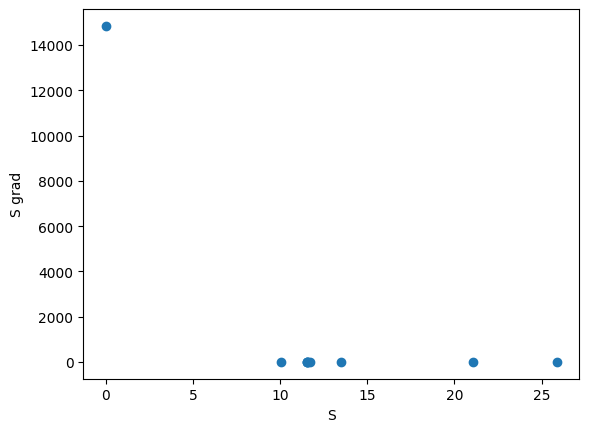

In [146]:
S = gen_s()
cond_ratio(S).backward()
plot_S_Sgrad(S)
S.grad

tensor([-5.6289e-28, -5.6544e-28, -5.5824e-28, -5.6158e-28, -5.6186e-28,
         5.5225e-21,  0.0000e+00, -8.6255e-28, -5.9205e-28, -5.7663e-28])

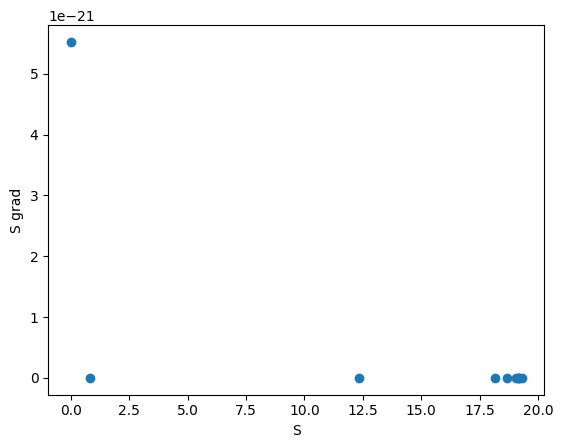

In [147]:
S = gen_s()
cond_exp(S).backward()
plot_S_Sgrad(S)
S.grad

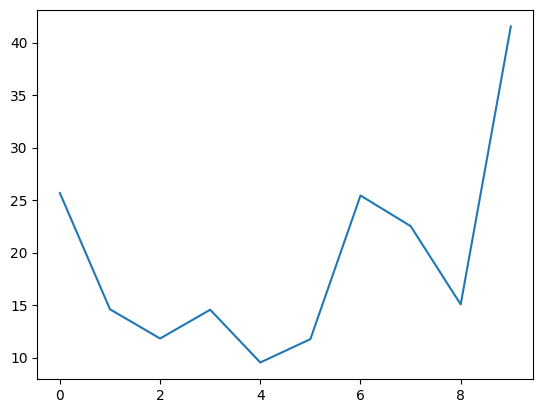

In [98]:
plt.plot(S.detach().numpy())